In [2]:
from google.colab import files
uploaded = files.upload()


Saving it-service-ticket-classification.csv to it-service-ticket-classification.csv


In [3]:
import pandas as pd

# Replace with your actual file name if different
df = pd.read_csv('it-service-ticket-classification.csv')

# View basic info
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ticket_id             200 non-null    object
 1   created_datetime      200 non-null    object
 2   updated_datetime      123 non-null    object
 3   submitted_by_user_id  200 non-null    object
 4   assigned_to_user_id   122 non-null    object
 5   department            188 non-null    object
 6   ticket_subject        200 non-null    object
 7   ticket_description    200 non-null    object
 8   category              200 non-null    object
 9   subcategory           200 non-null    object
 10  priority              200 non-null    object
 11  status                200 non-null    object
 12  resolution_notes      53 non-null     object
 13  resolved_datetime     53 non-null     object
 14  sla_due_datetime      200 non-null    object
 15  impact                169 non-null    ob

In [7]:
import os
# os.rename("it-service-ticket-classification.csv", "tickets.csv")

In [9]:
!pip install pandas numpy sklearn matplotlib seaborn plotly nltk spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
!pip install scikit-learn


In [12]:
df.head()        # see first 5 rows
df.columns       # see all column names
df.info()        # get data types and missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ticket_id             200 non-null    object
 1   created_datetime      200 non-null    object
 2   updated_datetime      123 non-null    object
 3   submitted_by_user_id  200 non-null    object
 4   assigned_to_user_id   122 non-null    object
 5   department            188 non-null    object
 6   ticket_subject        200 non-null    object
 7   ticket_description    200 non-null    object
 8   category              200 non-null    object
 9   subcategory           200 non-null    object
 10  priority              200 non-null    object
 11  status                200 non-null    object
 12  resolution_notes      53 non-null     object
 13  resolved_datetime     53 non-null     object
 14  sla_due_datetime      200 non-null    object
 15  impact                169 non-null    ob

In [15]:
# Convert created_datetime to datetime format
df['created_datetime'] = pd.to_datetime(df['created_datetime'], format='ISO8601')

In [16]:
# Show value counts for key columns
for col in ['priority', 'category', 'status']:
    print(f"\n{col}:\n", df[col].value_counts(normalize=True))



priority:
 priority
medium      0.400
high        0.290
low         0.175
critical    0.135
Name: proportion, dtype: float64

category:
 category
hardware    0.325
software    0.220
access      0.180
other       0.175
network     0.100
Name: proportion, dtype: float64

status:
 status
open           0.335
in_progress    0.315
resolved       0.265
pending        0.085
Name: proportion, dtype: float64


<Axes: title={'center': 'Tickets per Week'}, xlabel='created_datetime'>

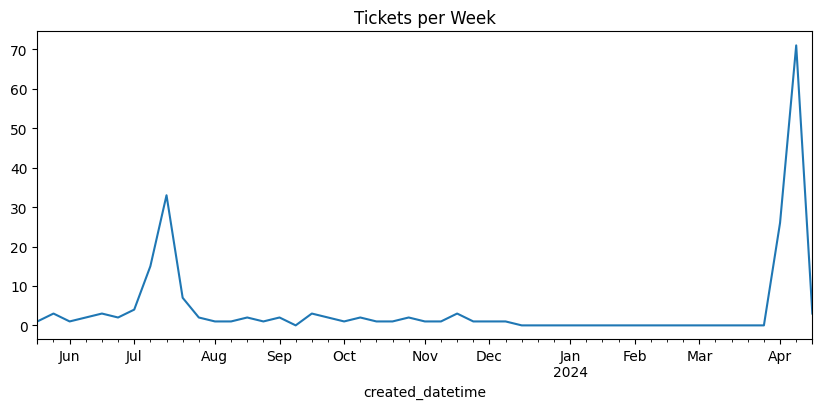

In [17]:
# Set datetime index
df.set_index('created_datetime', inplace=True)

# Plot weekly ticket volume
df.resample('W').size().plot(title="Tickets per Week", figsize=(10,4))


In [20]:
# Convert resolved_datetime to datetime
df['resolved_datetime'] = pd.to_datetime(df['resolved_datetime'], format='mixed', errors='coerce')

# Create a resolution time column (in hours)
df['resolution_time_hrs'] = (df['resolved_datetime'] - pd.Series(df.index)).dt.total_seconds() / 3600

# View some examples
display(df[['status', 'resolution_time_hrs']].head())

/tmp/ipython-input-1726726720.py:5: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  df['resolution_time_hrs'] = (df['resolved_datetime'] - pd.Series(df.index)).dt.total_seconds() / 3600


,status,resolution_time_hrs
created_datetime,,
2024-04-02 13:34:20+00:00,open,NaN
2024-04-02 14:12:05+00:00,in_progress,NaN
2024-04-03 09:00:00+00:00,in_progress,NaN
2024-04-03 10:15:13+00:00,open,NaN
2024-04-03 11:22:35+00:00,resolved,NaN


In [22]:
# Combine subject and description
df['text'] = df['ticket_subject'].fillna('') + " " + df['ticket_description'].fillna('')


In [23]:
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])


In [26]:
y = df['category']


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [29]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

      access       1.00      0.90      0.95        10
    hardware       0.65      1.00      0.79        11
     network       1.00      0.17      0.29         6
       other       1.00      1.00      1.00         6
    software       1.00      1.00      1.00         7

    accuracy                           0.85        40
   macro avg       0.93      0.81      0.80        40
weighted avg       0.90      0.85      0.82        40



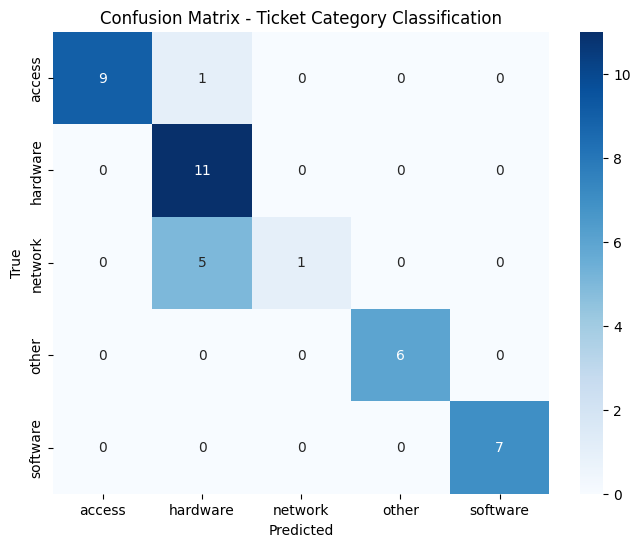

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ticket Category Classification')
plt.show()


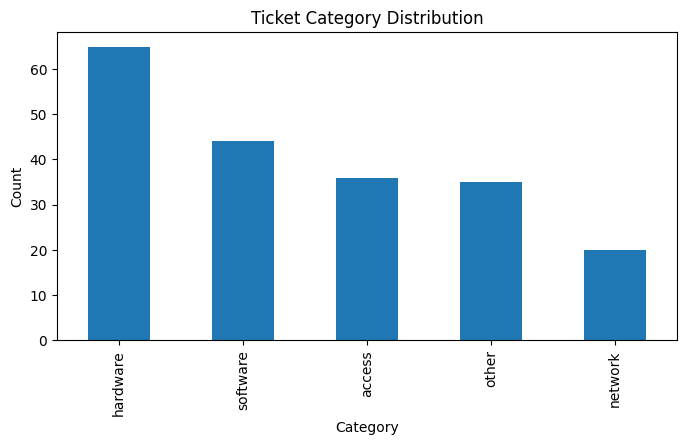

In [31]:
df['category'].value_counts().plot(kind='bar', title='Ticket Category Distribution', figsize=(8,4))
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


In [33]:
# Compare predicted vs actual
results_df = pd.DataFrame({
    'text': df.loc[y_test.index, 'text'].values,
    'true': y_test.values,
    'pred': y_pred
})

# Misclassified examples
misclassified = results_df[results_df['true'] != results_df['pred']]
misclassified.head(5)  # Show top 5 misclassifications

,text,true,pred
0,LAN connectivity issues PCs on the first floor...,network,hardware
1,LAN switch replacement required A LAN switch i...,network,hardware
4,LAN not available in meeting room No LAN conne...,network,hardware
5,LAN connection is unreliable Wired LAN connect...,network,hardware
10,Remote desktop not connecting Cannot connect t...,access,hardware
